# Analysis of the Incident Characteristics
## Load, Clean and Enrich the Data

In [1]:
# Import and configuration
import chart_config
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from config import *

In [2]:
# Load clean data from CSV
raw_data = pd.read_csv(incidents_clean_data_path)
# For the purposes of this analysis we don't care about incidents with no characteristics
total_count = len(raw_data.index)
raw_data = raw_data.dropna(how='any',subset=['Incident Info']).reset_index(drop=True)
print(f'There were {total_count - len(raw_data.index)} out of {total_count} incidents with no characteristics')
raw_data.head()

There were 326 out of 239677 incidents with no characteristics


,Year,City/County,State Name,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,Participant Age,Participant Age Group,Participant Gender,Participant Relationship,Participant Status,Participant Type,State Abbr
0,2013,Mckeesport,Pennsylvania,0,4,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,-79.8559,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,PA
1,2013,Hawthorne,California,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,-118.3330,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,CA
2,2013,Lorain,Ohio,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,OH
3,2013,Aurora,Colorado,4,0,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,CO
4,2013,Greensboro,North Carolina,2,2,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,NC


In [3]:
# There are several columns that we don't use for this analysis so lets drop them
clean_data = raw_data.drop(columns=[
    'State Name',
    'Participant Age', 
    'Participant Age Group', 
    'Participant Gender',
    'Participant Relationship',
    'Participant Status',
    'Participant Type'
])
clean_data.head()

,Year,City/County,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,State Abbr
0,2013,Mckeesport,0,4,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,-79.8559,PA
1,2013,Hawthorne,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,-118.3330,CA
2,2013,Lorain,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,-82.1377,OH
3,2013,Aurora,4,0,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,-104.8020,CO
4,2013,Greensboro,2,2,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,-79.9569,NC


In [4]:
# First lets split incident charactericis field and keep values in the sets (for faster operations)
empty_value_set = {''}
split_inc_info_data = clean_data.copy()
split_inc_info_data['Incident Info'] = split_inc_info_data['Incident Info'].apply(lambda x: set(x.split('|')).difference(empty_value_set))
split_inc_info_data.head()

,Year,City/County,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,State Abbr
0,2013,Mckeesport,0,4,{Possession of gun by felon or prohibited pers...,40.3467,-79.8559,PA
1,2013,Hawthorne,1,3,"{Shot - Dead (murder, accidental, suicide), Sh...",33.9090,-118.3330,CA
2,2013,Lorain,1,3,"{Shot - Dead (murder, accidental, suicide), Sh...",41.4455,-82.1377,OH
3,2013,Aurora,4,0,{Under the influence of alcohol or drugs (only...,39.6518,-104.8020,CO
4,2013,Greensboro,2,2,"{Shot - Wounded/Injured, Suicide^, Shot - Dead...",36.1140,-79.9569,NC


In [5]:
# Lets first take a look at all existing categories of the incidents (one incident can belong to multiple categories)
distinct_categories = reduce(lambda x,y: x.union(y), split_inc_info_data['Incident Info'])
print(f'There are {len(distinct_categories)} unique categories')
distinct_categories

There are 109 unique categories


{'ATF/LE Confiscation/Raid/Arrest',
 'Accidental Shooting',
 'Accidental Shooting - Death',
 'Accidental Shooting - Injury',
 'Accidental Shooting at a Business',
 'Accidental/Negligent Discharge',
 'Animal shot/killed',
 'Armed robbery with injury/death and/or evidence of DGU found',
 'Assault weapon (AR-15, AK-47, and ALL variants defined by law enforcement)',
 'Attempted Murder/Suicide (one variable unsuccessful)',
 'BB/Pellet/Replica gun',
 'Bar/club incident - in or around establishment',
 'Brandishing/flourishing/open carry/lost/found',
 'Car-jacking',
 'Child Involved Incident',
 'Child injured (not child shooter)',
 'Child injured by child',
 'Child injured self',
 'Child killed (not child shooter)',
 'Child killed by child',
 'Child killed self',
 'Child picked up & fired gun',
 'Child with gun - no shots fired',
 'Cleaning gun',
 'Concealed Carry License - Perpetrator',
 'Concealed Carry License - Victim',
 'Criminal act with stolen gun',
 'Defensive Use',
 'Defensive Use - C

## General Statistics

In [6]:
# Now lets take a look at the statistics for each category
category_related_data = {
    'Category': [],
    'Number of Incidents': [],
    'Number of Killed': [],
    'Number of Injured': []
}
for category in distinct_categories:
    category_related_data['Category'].append(category)
    filter_series = split_inc_info_data['Incident Info'].apply(lambda x: category in x)
    category_related_incidents = split_inc_info_data.loc[filter_series]
    category_related_data['Number of Incidents'].append(len(category_related_incidents.index))
    category_related_data['Number of Killed'].append(category_related_incidents['Number of Killed'].sum())
    category_related_data['Number of Injured'].append(category_related_incidents['Number of Injured'].sum())
cat_data = pd.DataFrame(category_related_data).sort_values('Number of Incidents', ascending=False).reset_index(drop=True)
cat_data.head()

,Category,Number of Incidents,Number of Killed,Number of Injured
0,Shot - Wounded/Injured,93926,9958,113987
1,"Shot - Dead (murder, accidental, suicide)",53409,59794,12147
2,Non-Shooting Incident,44837,19,1887
3,Shots Fired - No Injuries,35750,192,985
4,Possession (gun(s) found during commission of ...,30863,2232,5822


In [7]:
# Lets drop some generic categories (these will be present in most of the categories)
non_gen_cat_data = cat_data.iloc[4:].reset_index(drop=True)
non_gen_cat_data.head()

,Category,Number of Incidents,Number of Killed,Number of Injured
0,Possession (gun(s) found during commission of ...,30863,2232,5822
1,Armed robbery with injury/death and/or evidenc...,19723,3011,9061
2,Brandishing/flourishing/open carry/lost/found,19017,1502,3089
3,ATF/LE Confiscation/Raid/Arrest,17991,602,1275
4,Officer Involved Incident,17988,6509,6490


In [8]:
def multiliner(long_str):
    lines = []
    line = ''
    words = long_str.split()
    for word in words:
        line = f'{line} {word}' if line else f'{line}{word}'
        if len(line) > 30:
            lines.append(line)
            line = ''
    if line:
        lines.append(line)
    return '\n'.join(lines)

## Top 20 Categories by Number of Incidents

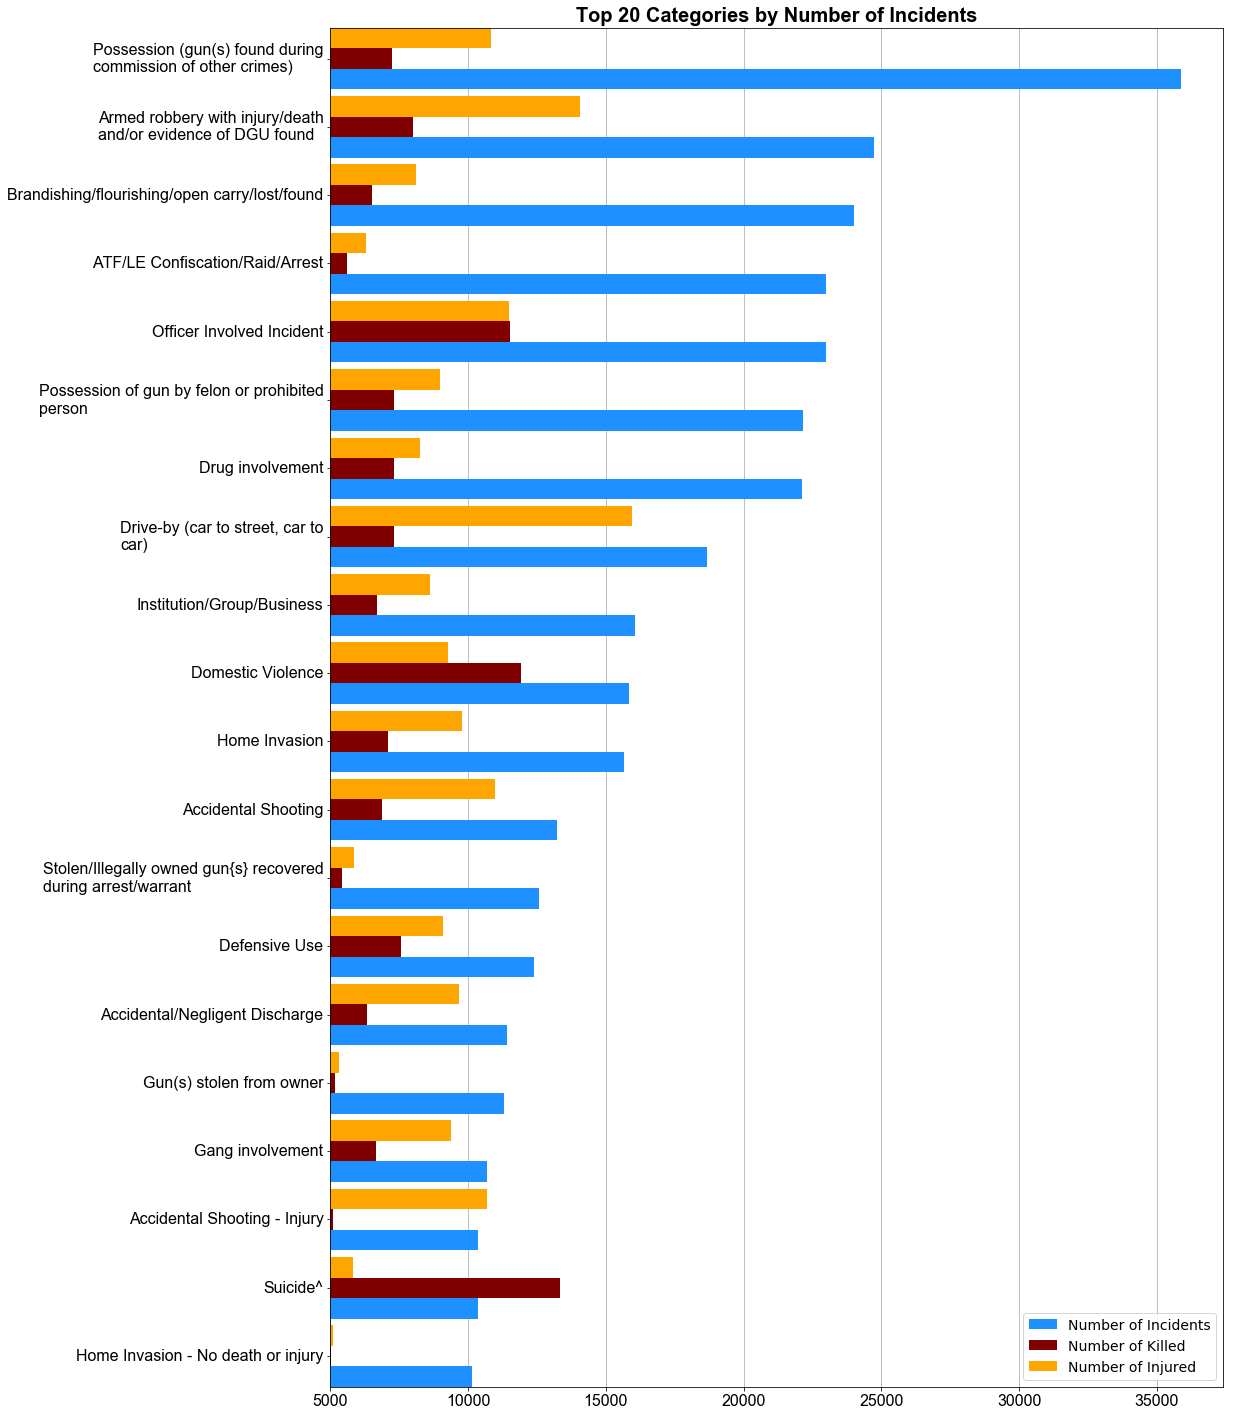

In [9]:
top_n_inc_data = non_gen_cat_data.head(20).iloc[::-1].reset_index(drop=True)
bar_width = 0.3
fig,ax = plt.subplots(figsize=(16,25))
n_inc = ax.barh(top_n_inc_data.index, top_n_inc_data['Number of Incidents'], bar_width, color='dodgerblue')
n_kil = ax.barh(top_n_inc_data.index + bar_width, top_n_inc_data['Number of Killed'], bar_width, color='maroon')
n_inj = ax.barh(top_n_inc_data.index + 2 * bar_width, top_n_inc_data['Number of Injured'], bar_width, color='orange')
ax.set_title('Top 20 Categories by Number of Incidents', fontdict=chart_config.title_font)
ax.set_yticks(top_n_inc_data.index + bar_width)
ax.set_yticklabels(top_n_inc_data['Category'].apply(multiliner),fontdict=chart_config.axis_font, wrap=True, ma='left',va='center')
ax.set_xticklabels([5000 * i for i in range(1,8)], fontdict=chart_config.axis_font)
ax.set_ylim(-0.15, 19.75)
ax.grid(True, axis='x')
ax.set_axisbelow(True)
ax.legend([n_inc, n_kil, n_inj],['Number of Incidents', 'Number of Killed', 'Number of Injured'], fontsize=14)
fig.savefig('../Output/Top 20 Categories by Number of Incidents.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

## Top 20 Categories by Number of Killed

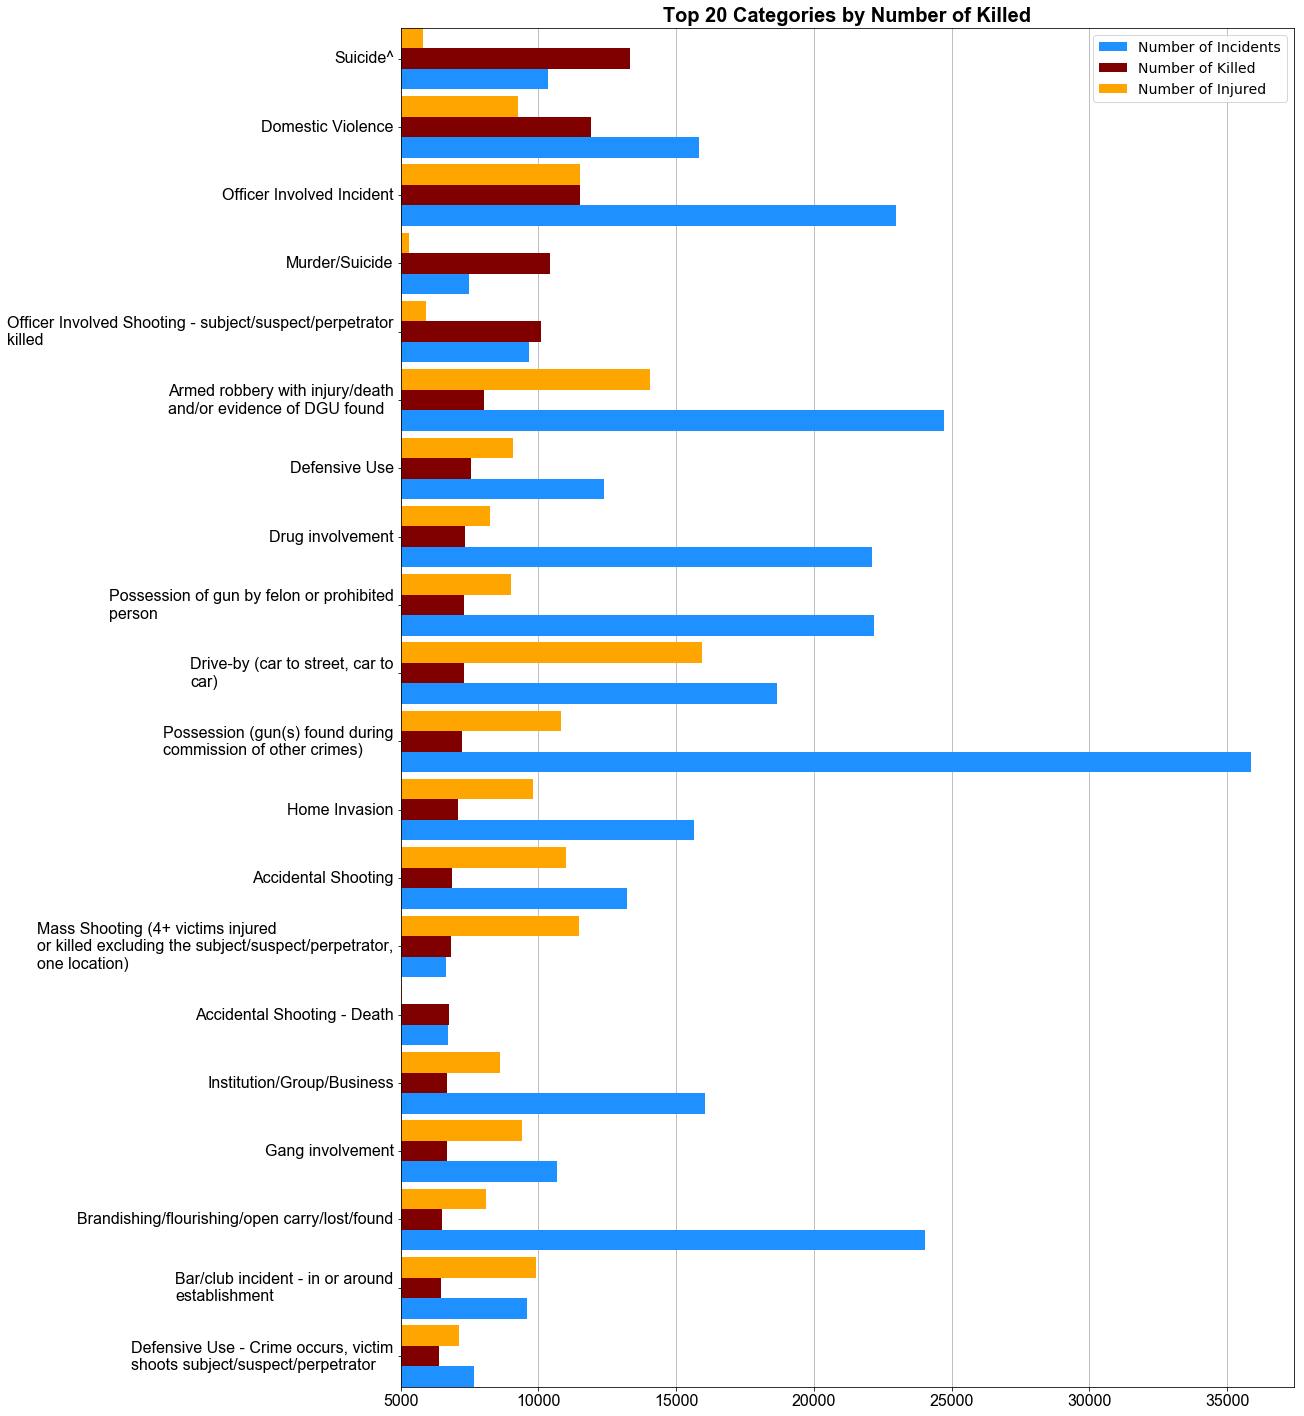

In [10]:
top_n_kil_data = non_gen_cat_data.sort_values('Number of Killed', ascending=False).head(20).iloc[::-1].reset_index(drop=True)
bar_width = 0.3
fig,ax = plt.subplots(figsize=(16,25))
n_inc = ax.barh(top_n_kil_data.index, top_n_kil_data['Number of Incidents'], bar_width, color='dodgerblue')
n_kil = ax.barh(top_n_kil_data.index + bar_width, top_n_kil_data['Number of Killed'], bar_width, color='maroon')
n_inj = ax.barh(top_n_kil_data.index + 2 * bar_width, top_n_kil_data['Number of Injured'], bar_width, color='orange')
ax.set_title('Top 20 Categories by Number of Killed', fontdict=chart_config.title_font)
ax.set_yticks(top_n_kil_data.index + bar_width)
ax.set_yticklabels(top_n_kil_data['Category'].apply(multiliner),fontdict=chart_config.axis_font, wrap=True, ma='left',va='center')
ax.set_xticklabels([5000 * i for i in range(1,8)], fontdict=chart_config.axis_font)
ax.set_ylim(-0.15, 19.75)
ax.grid(True, axis='x')
ax.set_axisbelow(True)
ax.legend([n_inc, n_kil, n_inj],['Number of Incidents', 'Number of Killed', 'Number of Injured'], fontsize=14)
fig.savefig('../Output/Top 20 Categories by Number of Killed.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

## Meta Categories

In [11]:
accidental_shooting = {
    'Accidental Use',
    'Accidental Shooting',
    'Accidental Shooting - Death',
    'Accidental Shooting - Injury',
    'Accidental Shooting at a Business',
    'Accidental/Negligent Discharge',
    'Thought gun was unloaded',
    'Self-Inflicted (not suicide or suicide attempt - NO PERP)',
    'Playing with gun',
    'Cleaning gun'}

misc = {
    'Not Interesting',
    'Animal shot/killed',
    'BB/Pellet/Replica gun',
    'Hunting accident',
    'Shots Fired - No Injuries',
    'Shots fired, no action (reported, no evidence found)',
    'Non-Aggression Incident',
    'Non-Shooting Incident',
    'Shot - Dead (murder, accidental, suicide)',
    'Shot - Wounded/Injured',
    'Ghost gun',
    'ShotSpotter',
    'Pistol-whipping',
    'Bar/club incident - in or around establishment',
    'LOCKDOWN/ALERT ONLY: No GV Incident Occurred Onsite',
    'NAV',
    'Implied Weapon',
    'Institution/Group/Business',
    'House party',
    'Brandishing/flourishing/open carry/lost/found',
    'Concealed Carry License - Victim',
    'Mistaken ID (thought it was an intruder/threat, was friend/family)',
    'Gun range/gun shop/gun show shooting',}

authorities_involved = {
    'ATF/LE Confiscation/Raid/Arrest',
    'TSA Action'
    'Officer Involved Incident',
    'Officer Involved Incident - Weapon involved but no shots fired',
    'Officer Involved Shooting - Accidental discharge - no injury required',
    'Officer Involved Shooting - Bystander killed',
    'Officer Involved Shooting - Bystander shot',
    'Officer Involved Shooting - Officer killed',
    'Officer Involved Shooting - Officer shot',
    'Officer Involved Shooting - Shots fired, no injury',
    'Officer Involved Shooting - subject/suspect/perpetrator killed',
    'Officer Involved Shooting - subject/suspect/perpetrator shot',
    'Officer Involved Shooting - subject/suspect/perpetrator suicide at standoff',
    'Officer Involved Shooting - subject/suspect/perpetrator suicide by cop',
    'Officer Involved Shooting - subject/suspect/perpetrator surrender at standoff',
    'Officer Involved Shooting - subject/suspect/perpetrator unarmed',
}

child_involved = {
    'Child Involved Incident',
    'Child injured (not child shooter)',
    'Child injured by child',
    'Child injured self',
    'Child killed (not child shooter)',
    'Child killed by child',
    'Child killed self',
    'Child picked up & fired gun',
    'Child with gun - no shots fired'
}

defensive_use = {
     'Defensive Use',
     'Defensive Use - Crime occurs, victim shoots subject/suspect/perpetrator',
     'Defensive Use - Good Samaritan/Third Party',
     'Defensive Use - Shots fired, no injury/death',
     'Defensive Use - Stand Your Ground/Castle Doctrine established',
     'Defensive Use - Victim stops crime',
     'Defensive Use - WITHOUT a gun',
     'Defensive use - No shots fired',
     'Home Invasion - subject/suspect/perpetrator injured',
     'Home Invasion - subject/suspect/perpetrator killed',
}

criminal = {
    'Armed robbery with injury/death and/or evidence of DGU found',
    'Assault weapon (AR-15, AK-47, and ALL variants defined by law enforcement)',
    'Car-jacking',
    'Criminal act with stolen gun',
    'Drive-by (car to street, car to car)',
    'Drug involvement',
    'Gang involvement',
    'Gun buy back action',
    'Gun shop robbery or burglary',
    'Gun(s) stolen from owner',
    'Guns stolen from law enforcement',
    'Hate crime',
    'Home Invasion',
    'Home Invasion - No death or injury',
    'Home Invasion - Resident injured',
    'Home Invasion - Resident killed',
    'Kidnapping/abductions/hostage',
    'Mass Murder (4+ deceased victims excluding the subject/suspect/perpetrator , one location)',
    'Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)',
    'Police Targeted',
    'Political Violence',
    'Possession (gun(s) found during commission of other crimes)',
    'Possession of gun by felon or prohibited person',
    'Road rage',
    'Stolen/Illegally owned gun{s} recovered during arrest/warrant',
    'Terrorism Involvement',
    'Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )',
    'Unlawful purchase/sale',
    'Workplace shooting (disgruntled employee)',
    'Sex crime involving firearm',
    'Concealed Carry License - Perpetrator',
    'Spree Shooting (multiple victims, multiple locations)',
    'Shootout (where VENN diagram of shooters and victims overlap)',
    'Domestic Violence',
    'Murder/Suicide',
    'Attempted Murder/Suicide (one variable unsuccessful)' 
}

school_related = {
    'Gun at school, no death/injury - elementary/secondary school',
    'Gun at school, no death/injury - university/college', 'School Incident',
    'School Shooting - elementary/secondary school',
    'School Shooting - university/college'    
}

murder_suicide = {
    'Suicide - Attempt',
    'Suicide^',
    'Murder/Suicide',
    'Attempted Murder/Suicide (one variable unsuccessful)'    
}

In [12]:
# Lets mark all the incidents with these metacategories
meta_cat_data = pd.concat([
    split_inc_info_data, 
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & accidental_shooting) > 0).rename('Accidental Shooting'),
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & authorities_involved) > 0).rename('Authorities/Police Involved'),
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & child_involved) > 0).rename('Child Involved'),
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & defensive_use) > 0).rename('Defensive Use'),
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & criminal) > 0).rename('Criminal'),
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & school_related) > 0).rename('School Related'),
    split_inc_info_data['Incident Info'].apply(lambda x: len(x & murder_suicide) > 0).rename('Murder/Suicide'),
], axis=1)
meta_cat_data.head()

,Year,City/County,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,State Abbr,Accidental Shooting,Authorities/Police Involved,Child Involved,Defensive Use,Criminal,School Related,Murder/Suicide
0,2013,Mckeesport,0,4,{Possession of gun by felon or prohibited pers...,40.3467,-79.8559,PA,False,False,False,False,True,False,False
1,2013,Hawthorne,1,3,"{Shot - Dead (murder, accidental, suicide), Sh...",33.9090,-118.3330,CA,False,False,False,False,True,False,False
2,2013,Lorain,1,3,"{Shot - Dead (murder, accidental, suicide), Sh...",41.4455,-82.1377,OH,False,False,False,False,False,False,False
3,2013,Aurora,4,0,{Under the influence of alcohol or drugs (only...,39.6518,-104.8020,CO,False,True,False,False,True,False,False
4,2013,Greensboro,2,2,"{Shot - Wounded/Injured, Suicide^, Shot - Dead...",36.1140,-79.9569,NC,False,False,False,False,True,False,True


In [13]:
meta_cat_names = meta_cat_data.columns[-7:]
#inc_by_meta = meta_cat_data.loc[[
#    'Accidental Shooting',
#    'Authorities/Police Involved',
#    'Child Involved', 
#    'Deffensive Use',
#    'Criminal',
#    'School Related',
#    'Murder/Suicide']]
inc_by_meta = pd.DataFrame({
    'Meta Category': meta_cat_names,
    'Number of Incidents': [meta_cat_data.loc[meta_cat_data[meta_cat], meta_cat].count() for meta_cat in meta_cat_names],
    'Number of Killed': [meta_cat_data.loc[meta_cat_data[meta_cat], 'Number of Killed'].sum() for meta_cat in meta_cat_names],
    'Number of Injured': [meta_cat_data.loc[meta_cat_data[meta_cat], 'Number of Injured'].sum() for meta_cat in meta_cat_names]
}).sort_values('Number of Incidents').reset_index(drop=True)
inc_by_meta

,Meta Category,Number of Incidents,Number of Killed,Number of Injured
0,Child Involved,2123,995,1759
1,School Related,2805,167,369
2,Murder/Suicide,6107,8791,1454
3,Defensive Use,7802,2787,4459
4,Accidental Shooting,8213,1863,5986
5,Authorities/Police Involved,33165,6724,7123
6,Criminal,108457,23559,44120


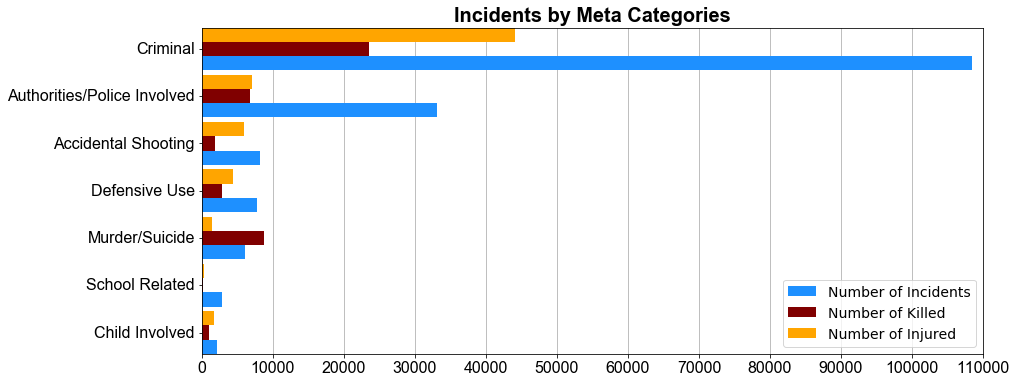

In [14]:
bar_width = 0.3
fig,ax = plt.subplots(figsize=(14,6))
n_inc = ax.barh(inc_by_meta.index, inc_by_meta['Number of Incidents'], bar_width, color='dodgerblue')
n_kil = ax.barh(inc_by_meta.index + bar_width, inc_by_meta['Number of Killed'], bar_width, color='maroon')
n_inj = ax.barh(inc_by_meta.index + 2 * bar_width, inc_by_meta['Number of Injured'], bar_width, color='orange')
ax.set_title('Incidents by Meta Categories', fontdict=chart_config.title_font)
ax.set_yticks(inc_by_meta.index + bar_width)
ax.set_yticklabels(inc_by_meta['Meta Category'],fontdict=chart_config.axis_font, va='center')
ax.set_xticks([10000 * i for i in range(0,12)])
ax.set_xticklabels([10000 * i for i in range(0,12)], fontdict=chart_config.axis_font)
ax.set_ylim(-0.15, 6.75)
ax.set_xlim(0, 110000)
ax.grid(True, axis='x')
ax.set_axisbelow(True)
ax.legend([n_inc, n_kil, n_inj],['Number of Incidents', 'Number of Killed', 'Number of Injured'], fontsize=14)
fig.savefig('../Output/Incidents by Meta Categories.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

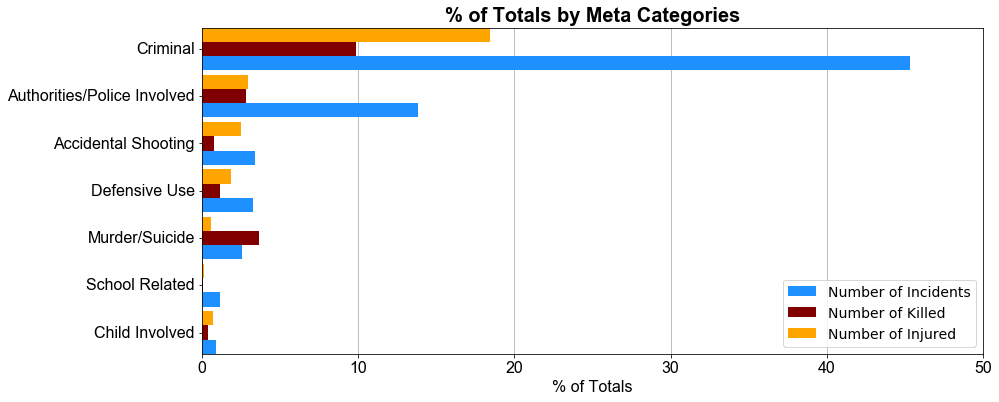

In [15]:
total_killed = clean_data['Number of Killed'].fillna(0).sum()
total_injured = clean_data['Number of Injured'].fillna(0).sum()
total_inc_number = len(clean_data.index)
inc_by_meta_prcnt = inc_by_meta.copy()

inc_by_meta_prcnt['Number of Incidents'] = inc_by_meta_prcnt['Number of Incidents'] / total_inc_number * 100.0
inc_by_meta_prcnt['Number of Killed'] = inc_by_meta_prcnt['Number of Killed'] / total_inc_number * 100.0
inc_by_meta_prcnt['Number of Injured'] = inc_by_meta_prcnt['Number of Injured'] / total_inc_number * 100.0

bar_width = 0.3
fig,ax = plt.subplots(figsize=(14,6))
n_inc = ax.barh(inc_by_meta_prcnt.index, inc_by_meta_prcnt['Number of Incidents'], bar_width, color='dodgerblue')
n_kil = ax.barh(inc_by_meta_prcnt.index + bar_width, inc_by_meta_prcnt['Number of Killed'], bar_width, color='maroon')
n_inj = ax.barh(inc_by_meta_prcnt.index + 2 * bar_width, inc_by_meta_prcnt['Number of Injured'], bar_width, color='orange')
ax.set_title('% of Totals by Meta Categories', fontdict=chart_config.title_font)
ax.set_xlabel('% of Totals', fontdict=chart_config.axis_font)
ax.set_yticks(inc_by_meta_prcnt.index + bar_width)
ax.set_yticklabels(inc_by_meta_prcnt['Meta Category'],fontdict=chart_config.axis_font, va='center')
ax.set_xticklabels([10 * i for i in range(0,6)], fontdict=chart_config.axis_font)
ax.set_ylim(-0.15, 6.75)
ax.set_xlim(0, 50)
ax.grid(True, axis='x')
ax.set_axisbelow(True)
ax.legend([n_inc, n_kil, n_inj],['Number of Incidents', 'Number of Killed', 'Number of Injured'], fontsize=14)
fig.savefig('../Output/Incidents by Meta Categories (Percentage).png', dpi=fig.dpi, bbox_inches='tight')
plt.show()